In [1]:
from hnn_core import calcium_model, read_params, simulate_dipole, average_dipoles
from hnn_core.viz import plot_dipole
import matplotlib.pyplot as plt
from copy import deepcopy
import pandas as pd
import pickle
import numpy as np
from hnn_core import MPIBackend

In [2]:
# load participant data 
df = pd.read_csv('HNN_data_TEP_dipole_0_300.txt', sep = ' ')
data = [line.split('\t') for line in df.iloc[:,0].tolist()]

partic_data = []
partic_data.append([float(x[0]) for x in data])
partic_data.append([float(x[1]) for x in data])

# load original params
fparams = "TEP_from_def_Liz_2newInputs_optimized.param"
original_params = read_params(fparams)

# load params from V2 param file
with open('param_files/net_TEP_calcium_params.pkl', 'rb') as f:
    V2_TEP_params = pickle.load(f)

In [3]:
def make_net_and_simulate(params, n_trials = 2, tstop=None):
    # make nets
    net = calcium_model(params=params, add_drives_from_params=True)

    # simulate dipoles
    if tstop is not None:
        with MPIBackend(n_procs=n_trials, mpi_cmd='mpiexec'):
            dpl = simulate_dipole(net, tstop=tstop, n_trials=n_trials)
    else: 
        with MPIBackend(n_procs=n_trials, mpi_cmd='mpiexec'):
            dpl = simulate_dipole(net, tstop=params["tstop"], n_trials=n_trials)
    return dpl, net

In [4]:
from hnn_core import jones_2009_model

def make_net_and_simulate_jones2009(params, n_trials = 2, tstop=None):
    # make nets
    net = jones_2009_model(params=params, add_drives_from_params=True)

    # simulate dipoles
    if tstop is not None:
        with MPIBackend(n_procs=n_trials, mpi_cmd='mpiexec'):
            dpl = simulate_dipole(net, tstop=tstop, n_trials=n_trials)
    else: 
        with MPIBackend(n_procs=n_trials, mpi_cmd='mpiexec'):
            dpl = simulate_dipole(net, tstop=params["tstop"], n_trials=n_trials)
    return dpl, net


In [5]:
def scale_and_smooth(dpls_list, window_len=10, scaling_factor=1):
    dpl_smoothed_list = [deepcopy(dpl) for dpl in dpls_list]
    for dpl in dpl_smoothed_list:
        for dpl_trial in dpl:
            dpl_trial.smooth(window_len).scale(scaling_factor)
    return dpl_smoothed_list

In [6]:
def make_plot(dpls, nets, scalars, data_scale=4, tstop=320, title_list = None, trial_idx = 0):
    for i in range(len(dpls)):
        fig, axes = plt.subplots(3, 2, sharex=True, figsize=(16, 12), constrained_layout=True)

        # plot 1: drives
        nets[i].cell_response.plot_spikes_hist(ax=axes[0][0], spike_types=['evprox', 'evdist'], trial_idx=trial_idx, show=False)

        # plot 2: cell response
        # nets[i].cell_response.plot_spikes_hist(ax=axes[1][0], spike_types=['L2_pyramidal','L2_basket'], trial_idx=trial_idx, show=False)
        nets[i].cell_response.plot_spikes_hist(ax=axes[1][0], spike_types=['L5_pyramidal', 'L2_pyramidal', 'L5_basket', 'L2_basket', ], trial_idx=trial_idx, show=False)

        # plot 3: cell spiking
        nets[i].cell_response.plot_spikes_raster(ax=axes[2][0], trial_idx=trial_idx, show=False)

        # plot 4: dipole, agg and data 
        # plot_dipole(dpls[i], ax = axes[0][1], layer='agg', show=False)
        plot_dipole(dpls[i], ax = axes[0][1], layer='agg', show=False, average=True)
        axes[0][1].plot(np.array(partic_data[0][:tstop]), np.array(partic_data[1][:tstop])*data_scale)
        
        ymin, ymax = axes[0][1].get_ylim()

        # plot 5: dipole, layer 2/3
        plot_dipole(dpls[i], ax = axes[1][1], layer='L2', show=False)
        axes[1][1].set_ylim(ymin, ymax)

        # plot 6: dipole, layer 5
        plot_dipole(dpls[i], ax = axes[2][1], layer='L5', show=False)
        axes[2][1].set_ylim(ymin, ymax)
        axes[0][1].set_xlim(0,tstop)

        if title_list is None:
            fig.suptitle(f'scalar {scalars[i]}')
        else:
            fig.suptitle(title_list[i])

In [7]:
def simulate_from_params(params_list, n_trials=2):
    dpls = []
    nets = []
    for params in params_list:
        dpl, net = make_net_and_simulate(params,n_trials=n_trials)
        dpls.append(dpl)
        nets.append(net)
    smoothed_dpls = scale_and_smooth(dpls)
    return nets, smoothed_dpls

In [8]:
print(V2_TEP_params['gbar_evdist_1_*'])

{
    "gbar_evdist_1_L2Basket_ampa": 0.279149,
    "gbar_evdist_1_L2Basket_nmda": 0.067619,
    "gbar_evdist_1_L2Pyr_ampa": 0.006318,
    "gbar_evdist_1_L2Pyr_nmda": 0.030266,
    "gbar_evdist_1_L5Pyr_ampa": 0.407355,
    "gbar_evdist_1_L5Pyr_nmda": 1.051708
}


In [9]:
just_dist1_params = deepcopy(V2_TEP_params)
dist1_scalar = 0.62
prox1_scalar = 0.02
prox1_t_change = 6
dist2_scalar = 0.15
dist2_sd_scalar = 2
prox2_scalar = 0.5

params_to_clear = [
                    # just_dist1_params['gbar_evdist_1_*'], 
                    just_dist1_params['gbar_evdist_3_*'],
                    # just_dist1_params['gbar_evprox_1_*'],
                    just_dist1_params['gbar_evprox_2_*'],
                    # just_dist1_params['gbar_evprox_3_*'],
                    ]
params_to_clear = [element for nested_list in params_to_clear for element in nested_list]


for param in just_dist1_params['gbar_evdist_2*']:
    just_dist1_params[param] = dist1_scalar * just_dist1_params[param]

for param in just_dist1_params['gbar_evprox_1_*']:
    just_dist1_params[param] = prox1_scalar * just_dist1_params[param]
just_dist1_params['t_evprox_1'] += prox1_t_change

for param in just_dist1_params['gbar_evdist_1_*']:
    just_dist1_params[param] = dist2_scalar * just_dist1_params[param]
just_dist1_params['sigma_t_evdist_1'] =  just_dist1_params['sigma_t_evdist_1'] * dist2_sd_scalar

for param in just_dist1_params['gbar_evprox_3_*']:
    just_dist1_params[param] = prox2_scalar * just_dist1_params[param]

for param in just_dist1_params['gbar_evdist_3_*']:
    just_dist1_params[param] = 0.3 * just_dist1_params[param]

for param in just_dist1_params['gbar_evprox_2_*']:
    just_dist1_params[param] = 0.7 * just_dist1_params[param]

# for param in params_to_clear:
#     just_dist1_params[param] = 0

print(just_dist1_params)

{
    "L2Basket_Gauss_A_weight": 0.0,
    "L2Basket_Gauss_mu": 2000.0,
    "L2Basket_Gauss_sigma": 3.6,
    "L2Basket_Pois_A_weight_ampa": 0.0,
    "L2Basket_Pois_A_weight_nmda": 0.0,
    "L2Basket_Pois_lamtha": 0.0,
    "L2Pyr_Gauss_A_weight": 0.0,
    "L2Pyr_Gauss_mu": 2000.0,
    "L2Pyr_Gauss_sigma": 3.6,
    "L2Pyr_Pois_A_weight_ampa": 0.0,
    "L2Pyr_Pois_A_weight_nmda": 0.0,
    "L2Pyr_Pois_lamtha": 0.0,
    "L2Pyr_ampa_e": 0.0,
    "L2Pyr_ampa_tau1": 0.5,
    "L2Pyr_ampa_tau2": 5.0,
    "L2Pyr_apical1_L": 306.0,
    "L2Pyr_apical1_diam": 4.08,
    "L2Pyr_apicaloblique_L": 340.0,
    "L2Pyr_apicaloblique_diam": 3.91,
    "L2Pyr_apicaltrunk_L": 59.5,
    "L2Pyr_apicaltrunk_diam": 4.25,
    "L2Pyr_apicaltuft_L": 238.0,
    "L2Pyr_apicaltuft_diam": 3.4,
    "L2Pyr_basal1_L": 85.0,
    "L2Pyr_basal1_diam": 4.25,
    "L2Pyr_basal2_L": 255.0,
    "L2Pyr_basal2_diam": 2.72,
    "L2Pyr_basal3_L": 255.0,
    "L2Pyr_basal3_diam": 2.72,
    "L2Pyr_dend_Ra": 200.0,
    "L2Pyr_dend_cm": 0.619

In [11]:
with open(f'param_files/net_TEP_calcium_params_v3.pkl', 'wb') as file:
    pickle.dump(just_dist1_params, file)

In [65]:
just_dist1_dpl, just_dist1_net = make_net_and_simulate(just_dist1_params, n_trials = 3)
smoothed_just_dist1_dpl = scale_and_smooth([just_dist1_dpl])

MPI will run 3 trial(s) sequentially by distributing network neurons over 3 processes.
numprocs=3
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
Loading custom mechanism files from /opt/anaconda3/envs/hnn_core/lib/python3.8/site-packages/hnn_core/mod/arm64/.libs/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /opt/anaconda3/envs/hnn_core/lib/python3.8/site-packages/hnn_core/mod/arm64/.libs/libnrnmech.so
Loadin

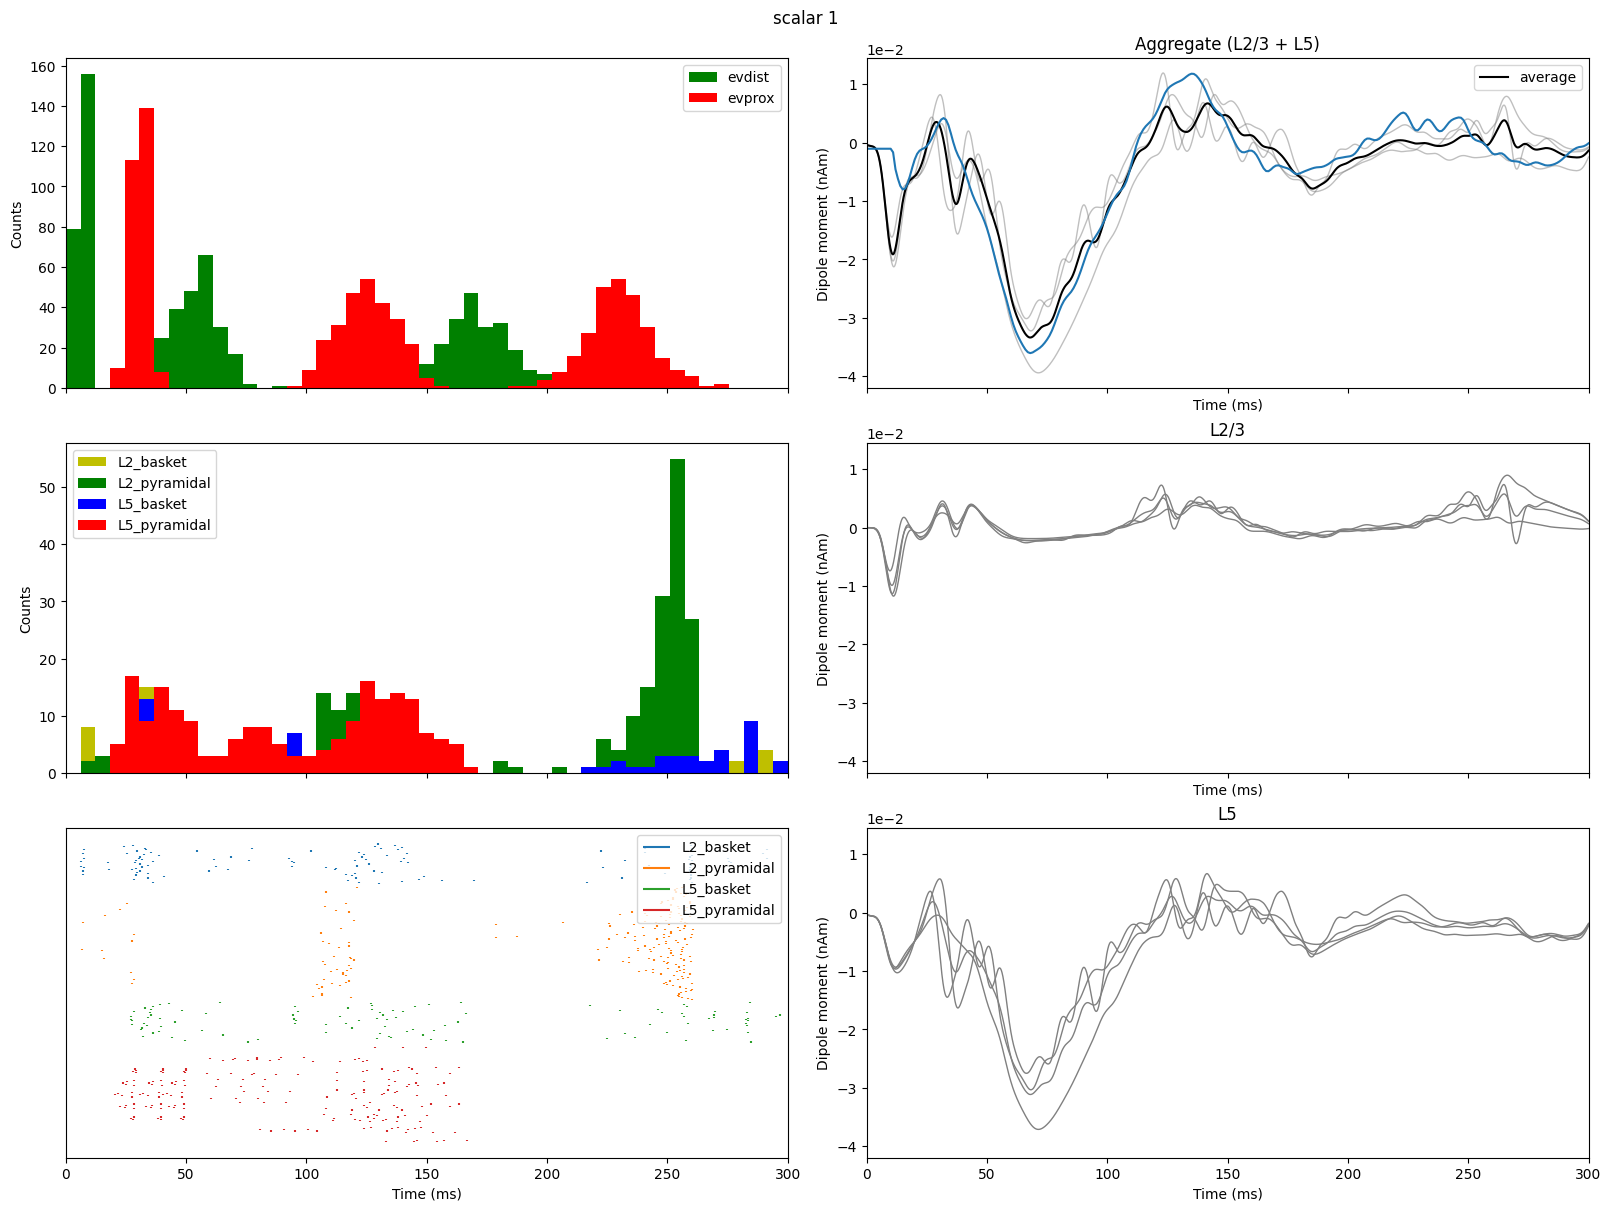

In [66]:
smoothed_just_dist1_dpl = scale_and_smooth([just_dist1_dpl],window_len=10)
make_plot(smoothed_just_dist1_dpl, [just_dist1_net], [1], tstop=300)

<h1> weaker dist2

In [56]:
# scale down the prox_2 drives 
prox_2_scalars = [0.5, 0.2]
# prox_2_sd_scalars = [2.0, 2.0]

prox2_params_list = [just_dist1_params.copy() for _ in range(len(prox_2_scalars))]

for params, scalar in zip(prox2_params_list, prox_2_scalars):
    for param in params['gbar_evprox_3*']:
        params[param] = scalar * params[param]
        
# for params, scalar in zip(dist2_params_list, prox_2_scalars):
#     params['sigma_t_evdist_1'] = scalar * params['sigma_t_evdist_1']

print(prox2_params_list[0]['gbar_evprox_3*'])  
print(prox2_params_list[1]['gbar_evprox_3*'])    

{
    "gbar_evprox_3_L2Basket_ampa": 4.5,
    "gbar_evprox_3_L2Basket_nmda": 12.5,
    "gbar_evprox_3_L2Pyr_ampa": 0.6465000000000001,
    "gbar_evprox_3_L2Pyr_nmda": 0.0,
    "gbar_evprox_3_L5Basket_ampa": 0.748,
    "gbar_evprox_3_L5Basket_nmda": 12.5,
    "gbar_evprox_3_L5Pyr_ampa": 0.043750000000000004,
    "gbar_evprox_3_L5Pyr_nmda": 0.0
}
{
    "gbar_evprox_3_L2Basket_ampa": 1.8,
    "gbar_evprox_3_L2Basket_nmda": 5.0,
    "gbar_evprox_3_L2Pyr_ampa": 0.25860000000000005,
    "gbar_evprox_3_L2Pyr_nmda": 0.0,
    "gbar_evprox_3_L5Basket_ampa": 0.2992,
    "gbar_evprox_3_L5Basket_nmda": 5.0,
    "gbar_evprox_3_L5Pyr_ampa": 0.0175,
    "gbar_evprox_3_L5Pyr_nmda": 0.0
}


MPI will run 3 trial(s) sequentially by distributing network neurons over 3 processes.
numprocs=3
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
Loading custom mechanism files from /opt/anaconda3/envs/hnn_core/lib/python3.8/site-packages/hnn_core/mod/arm64/.libs/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /opt/anaconda3/envs/hnn_core/lib/python3.8/site-packages/hnn_core/mod/arm64/.libs/libnrnmech.so
Loadin

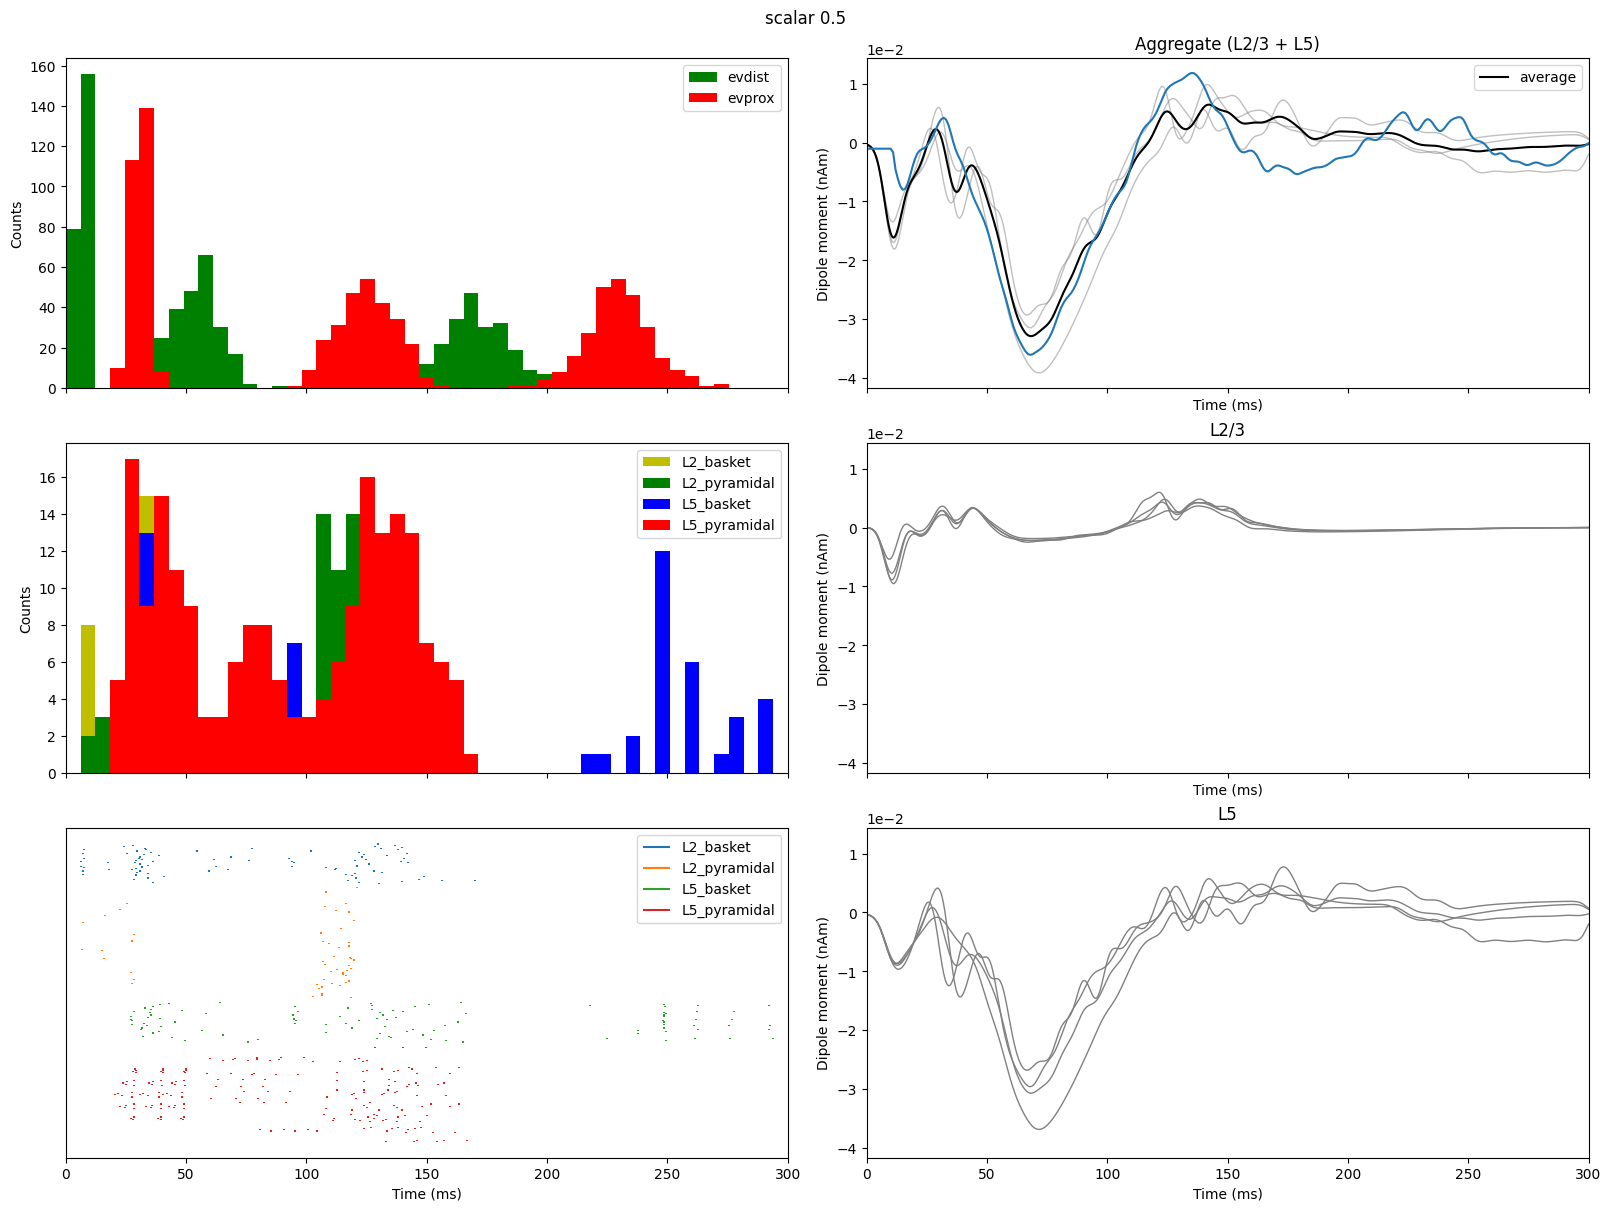

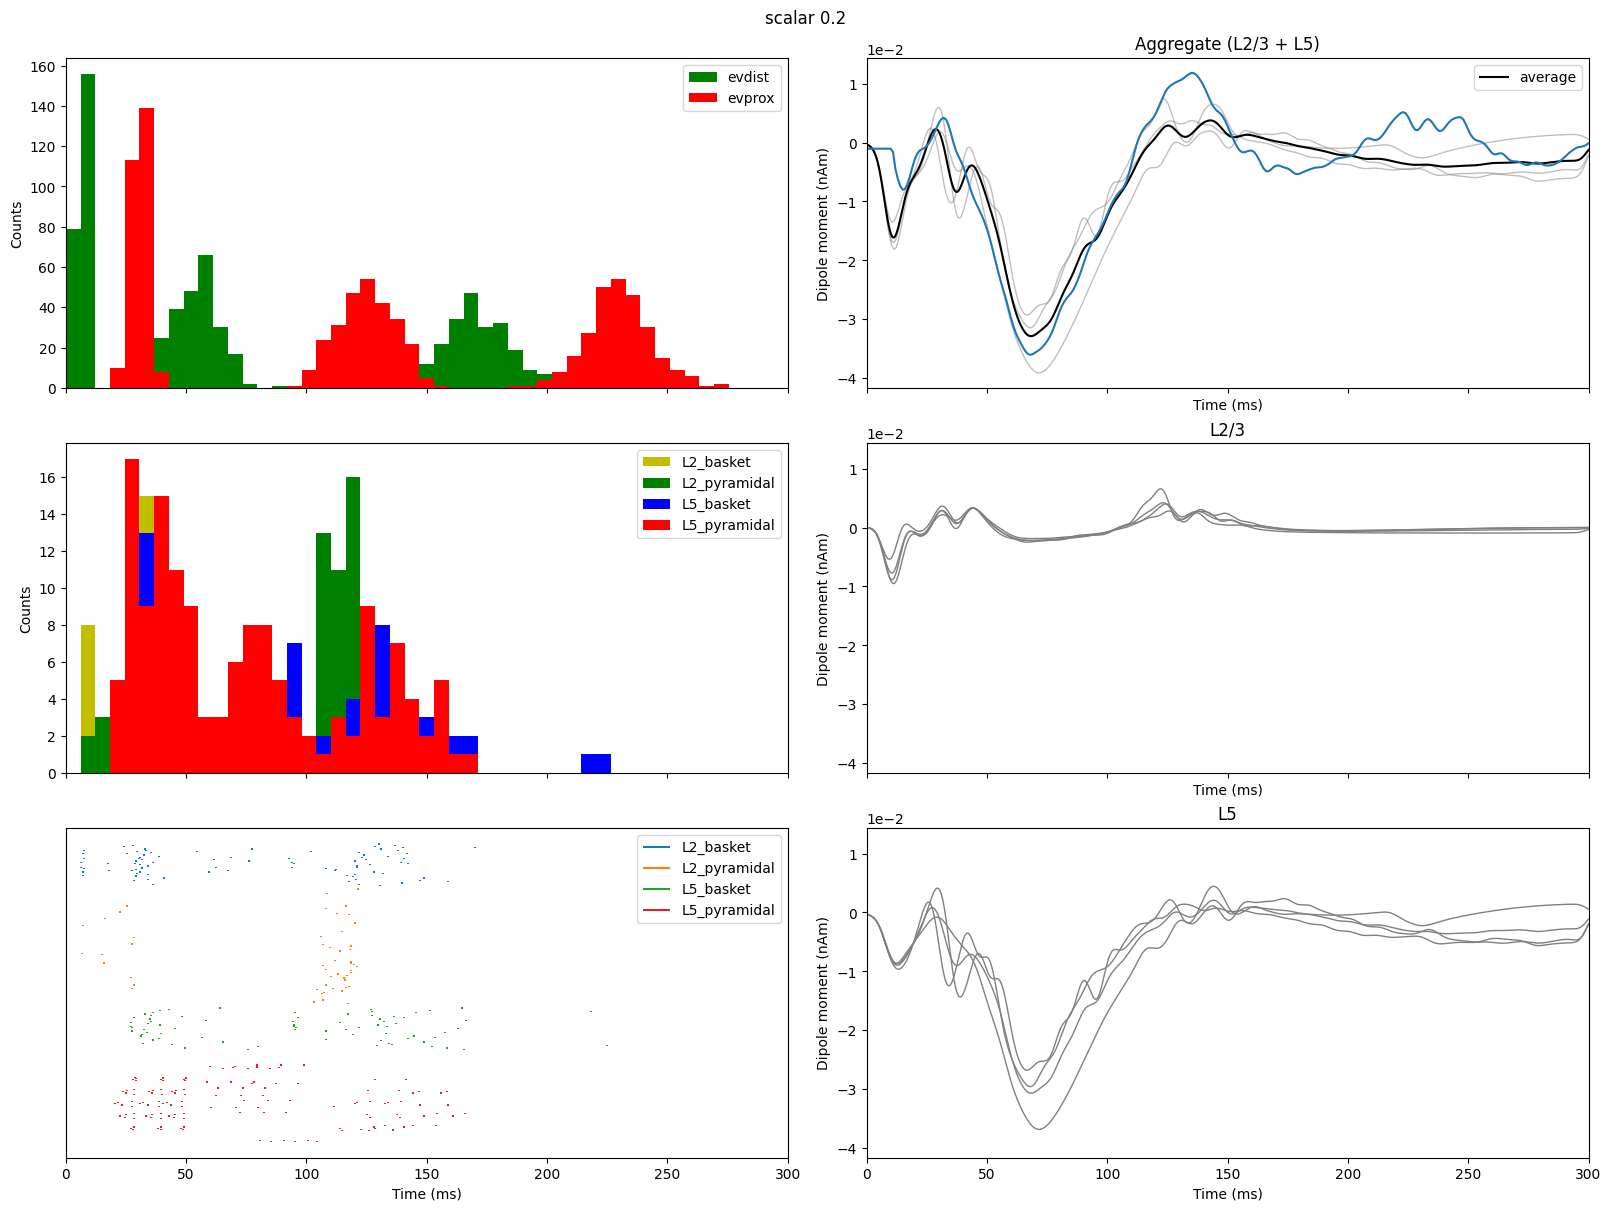

In [57]:
prox2_nets, prox2_dpls = simulate_from_params(prox2_params_list, n_trials=3)
smoothed_prox2_dpls = scale_and_smooth(prox2_dpls,window_len=10)
make_plot(smoothed_prox2_dpls, prox2_nets, prox_2_scalars, tstop=300)

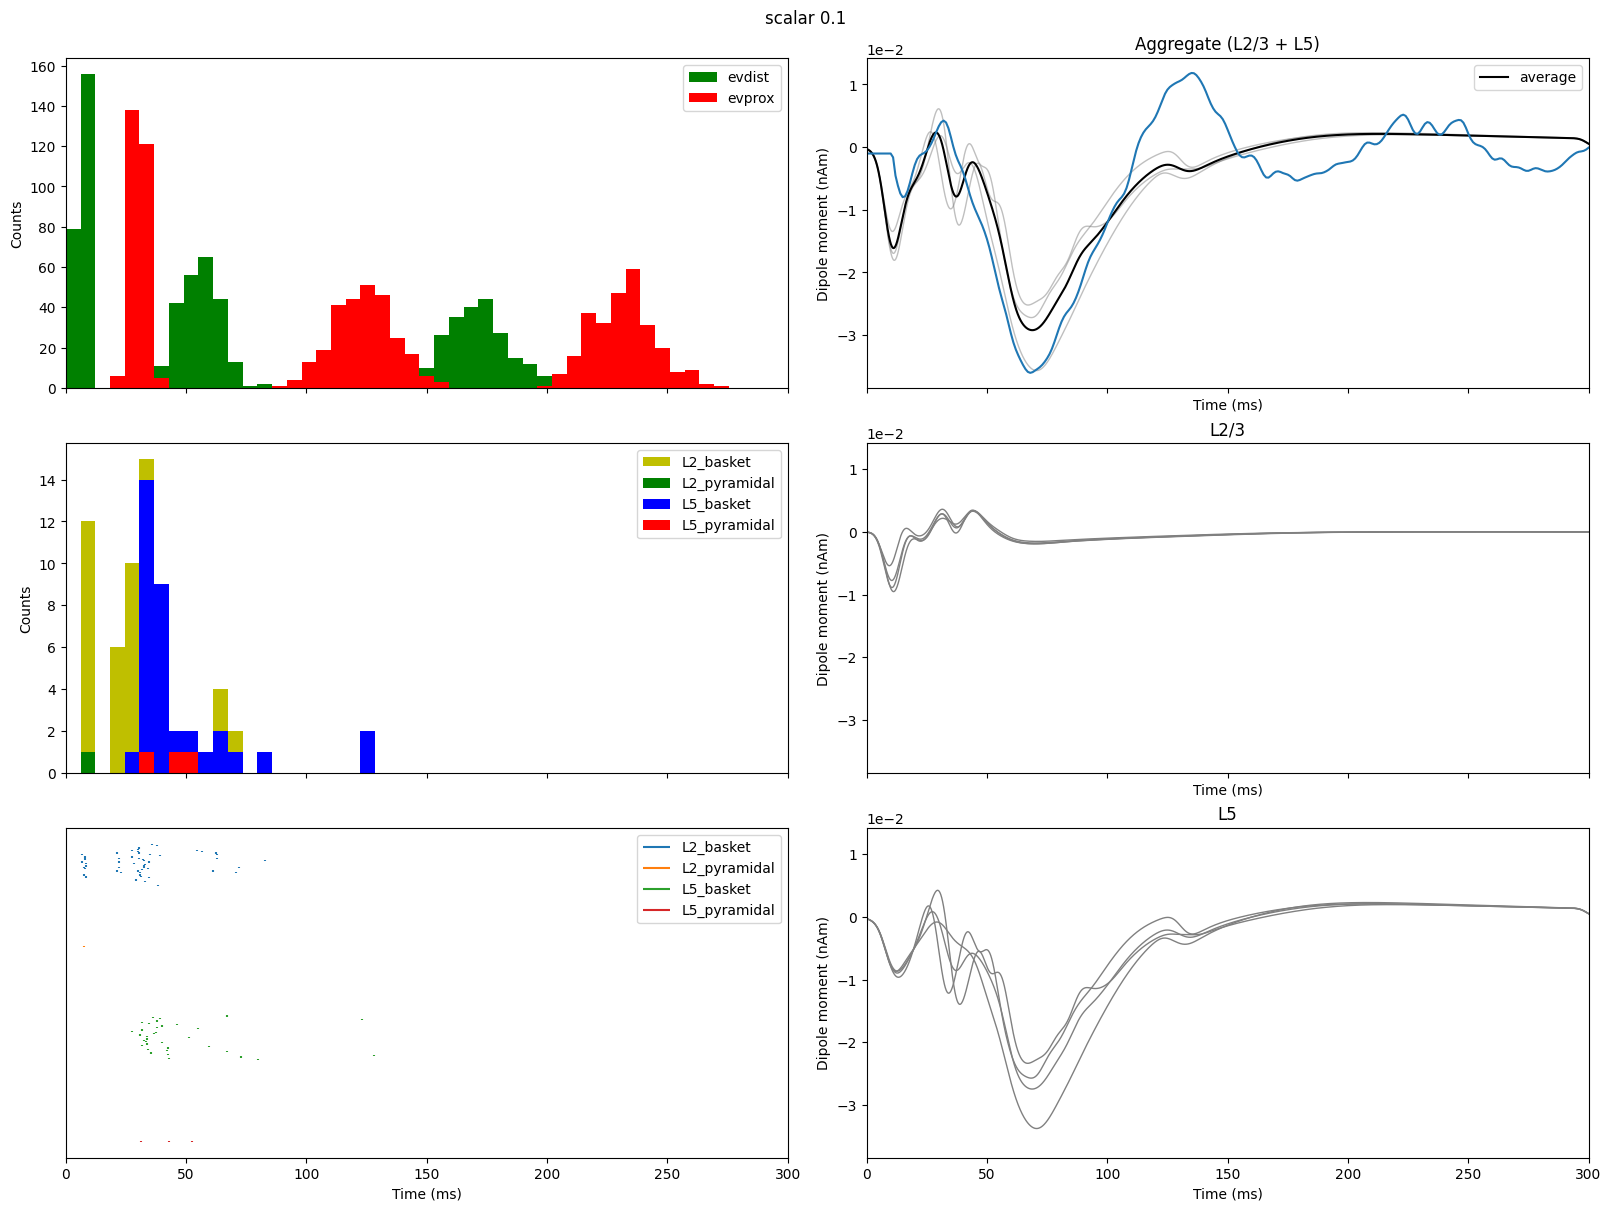

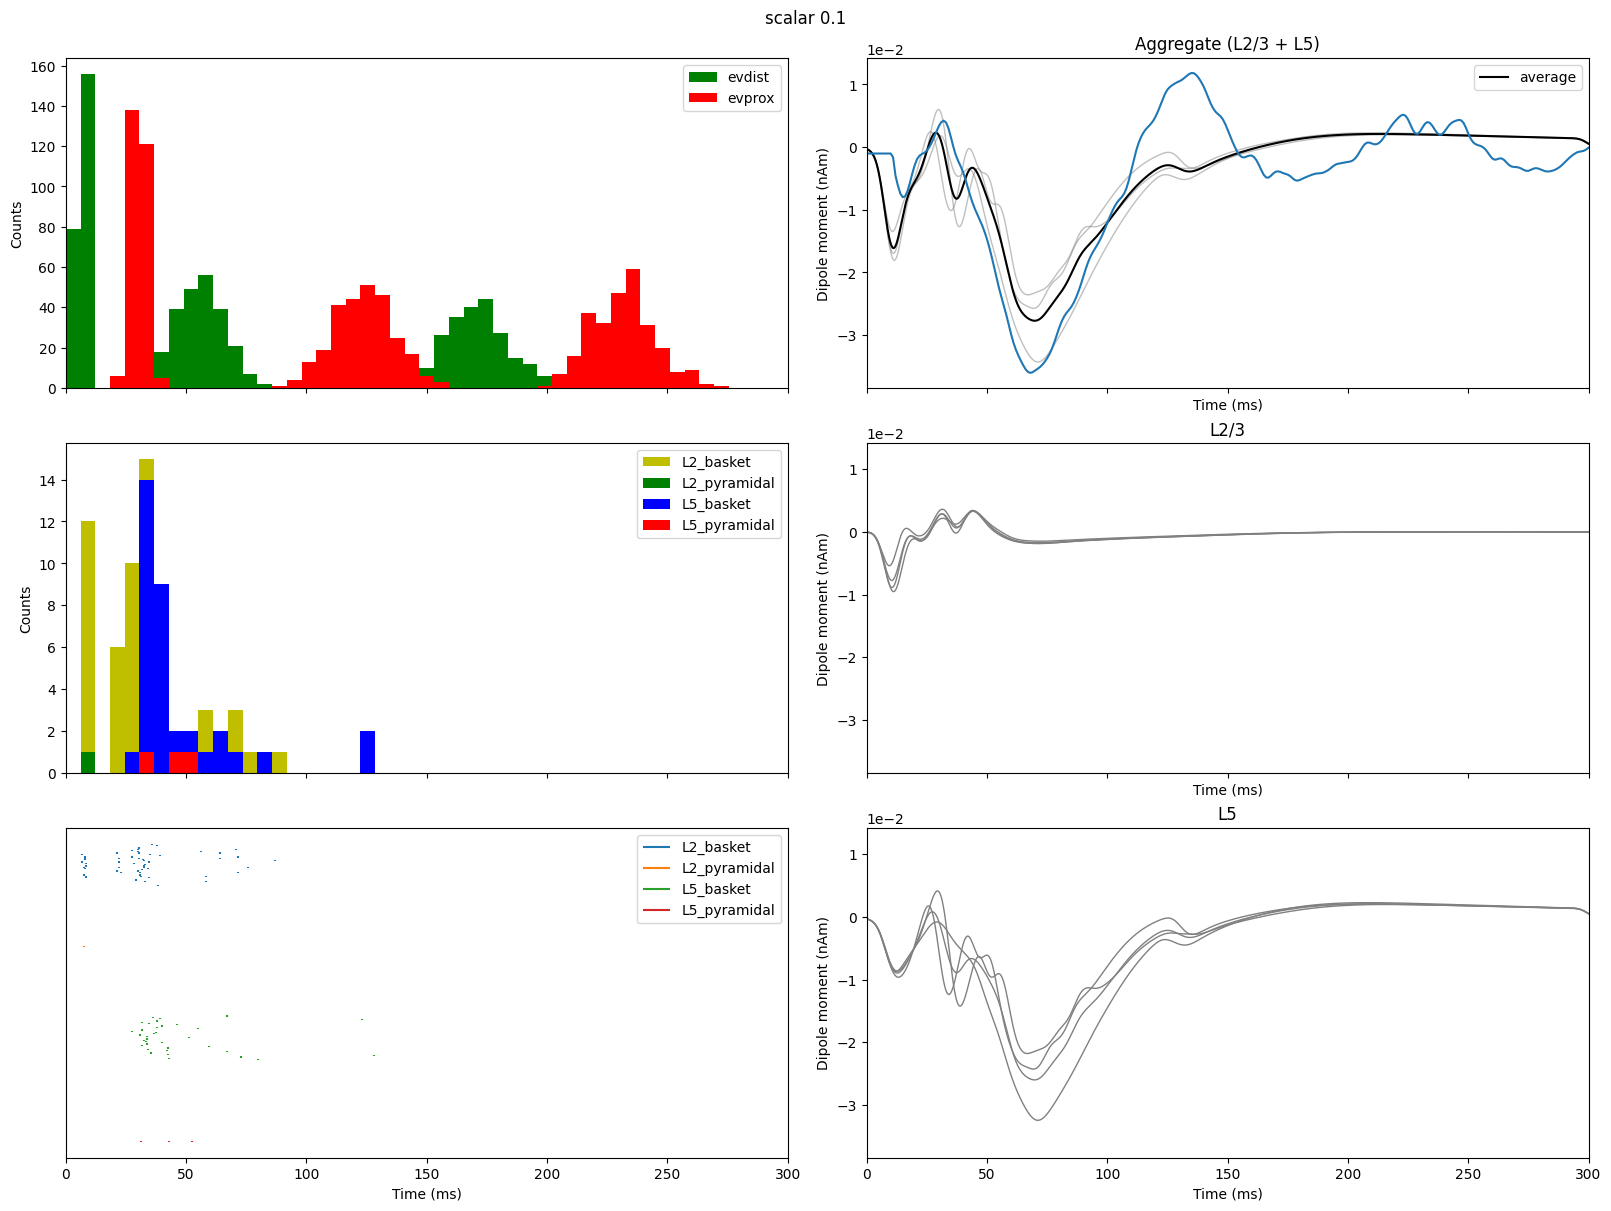

In [41]:
dist2_dpls_smoothed = scale_and_smooth(dist2_dpls,window_len=10)
make_plot(dist2_dpls_smoothed, dist2_nets, dist_2_scalars, tstop=300,trial_idx=1)

<h1>Weaker prox1

In [63]:
# scale down the dist_1 drives 
prox_1_scalars = [0.02, 0.02]
prox_1_t_scalars = [5,6]

prox1_params_list = [just_dist1_params.copy() for _ in range(len(prox_1_t_scalars))]

for params, scalar in zip(prox1_params_list, prox_1_scalars):
    for param in params['gbar_evprox_1*']:
        params[param] = scalar * params[param]

for params, scalar in zip(prox1_params_list, prox_1_t_scalars):
    params['t_evprox_1'] = scalar + params['t_evprox_1']
        

print(prox1_params_list[0]['t_evprox_1'])  
print(prox1_params_list[1]['t_evprox_1'])  
# print(dist1_params_list[1]['*evdist_2*'])    

29.472788
30.472788


MPI will run 3 trial(s) sequentially by distributing network neurons over 3 processes.
numprocs=3
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
Loading custom mechanism files from /opt/anaconda3/envs/hnn_core/lib/python3.8/site-packages/hnn_core/mod/arm64/.libs/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /opt/anaconda3/envs/hnn_core/lib/python3.8/site-packages/hnn_core/mod/arm64/.libs/libnrnmech.so
Loadin

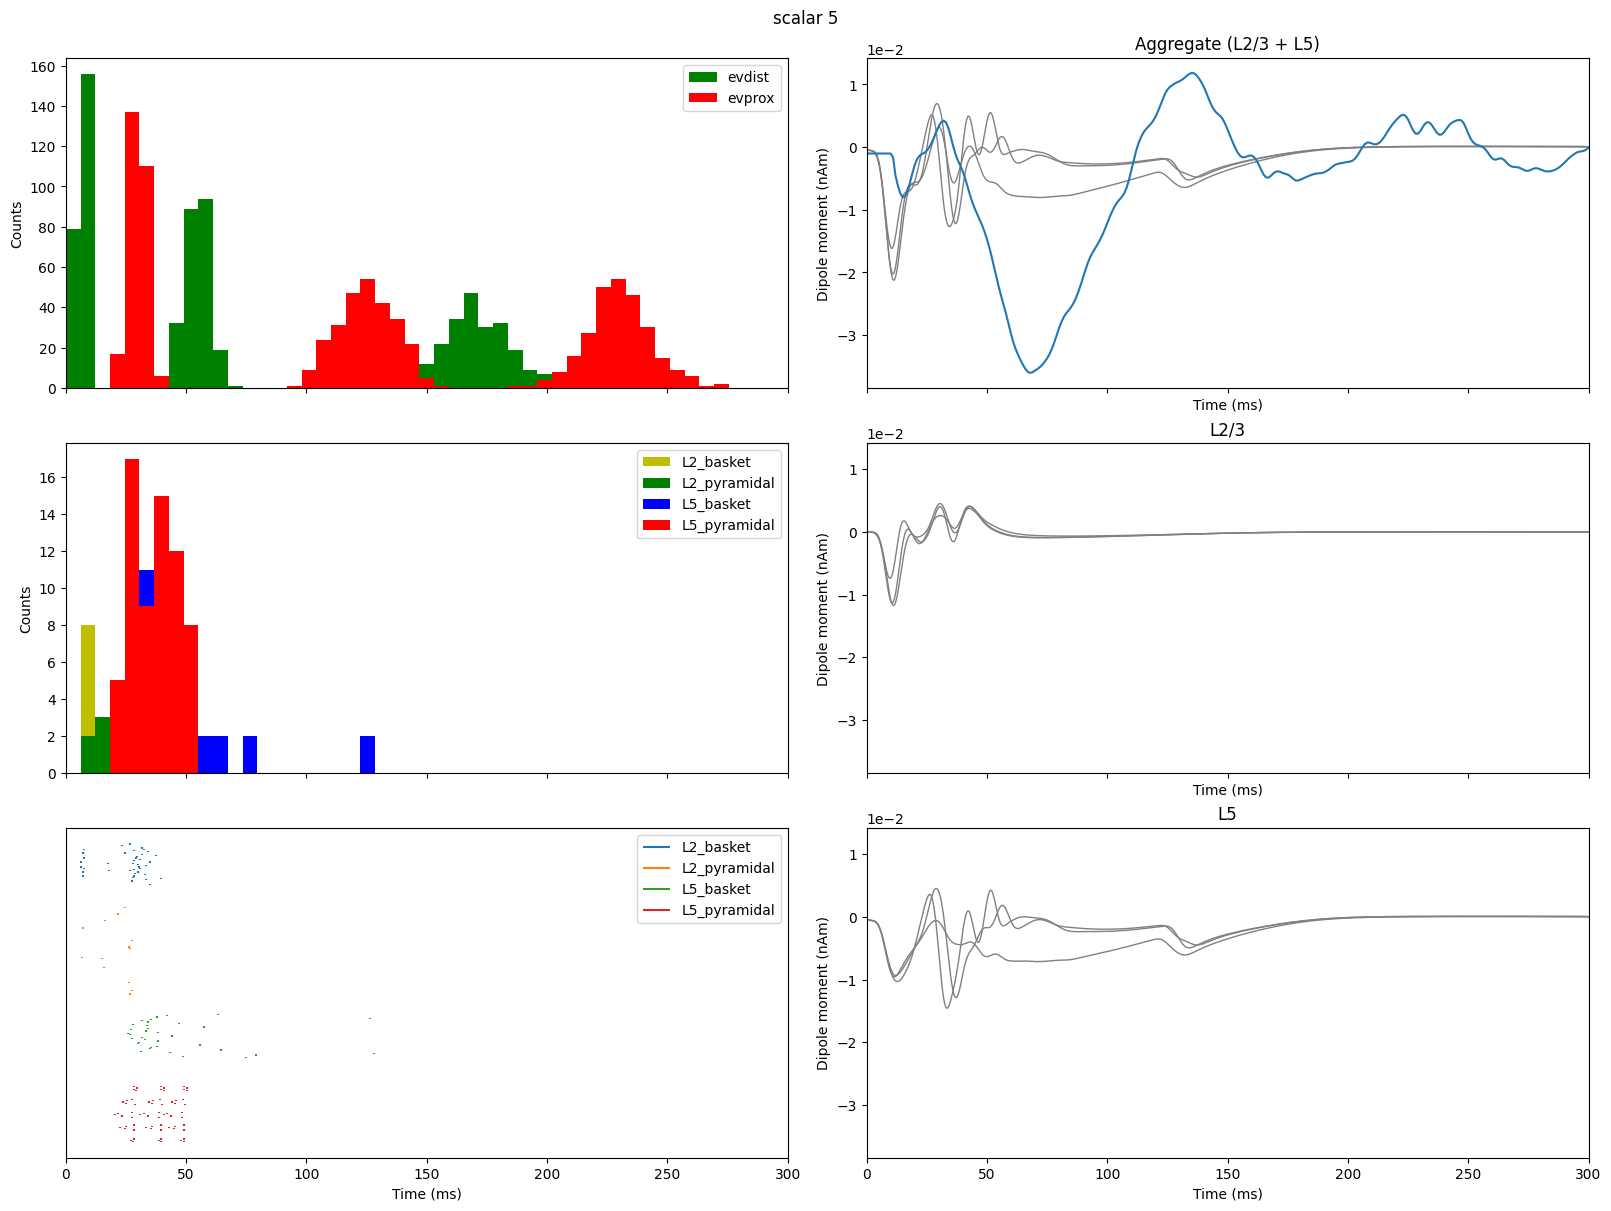

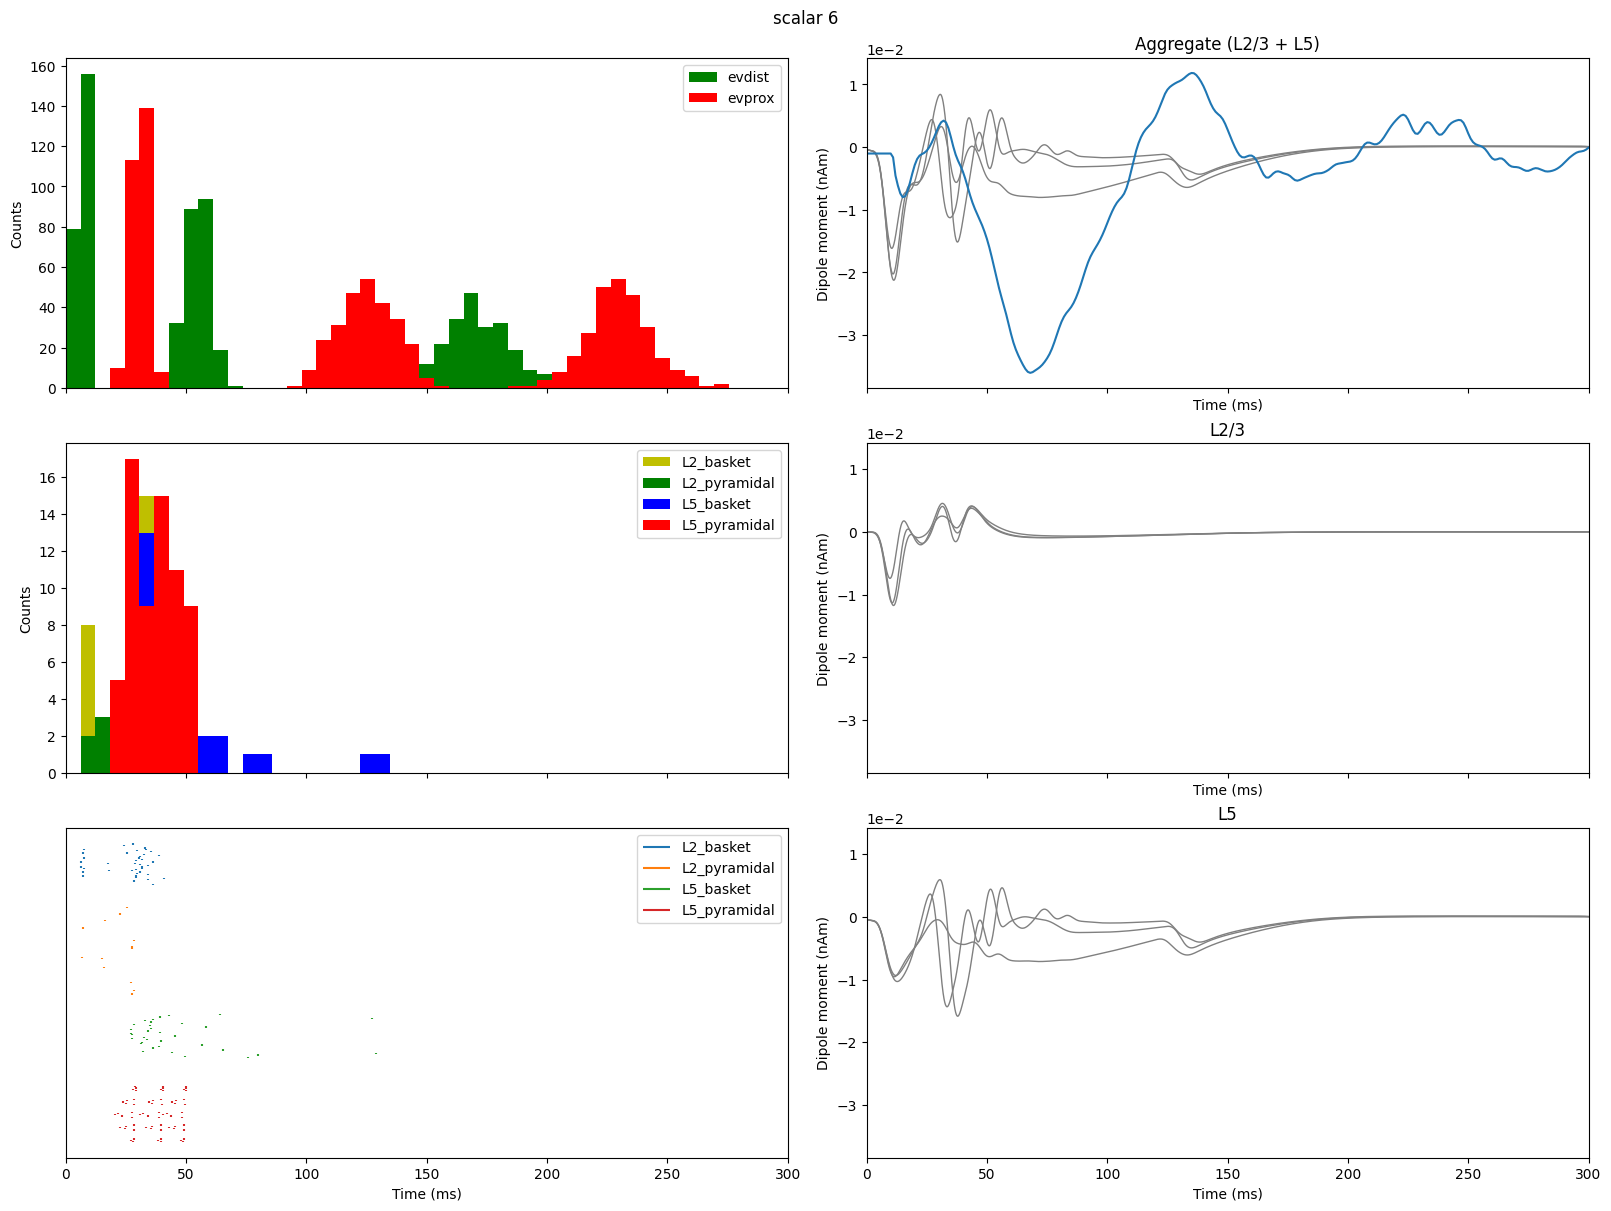

In [64]:
prox1_nets, prox1_dpls = simulate_from_params(prox1_params_list, n_trials=3)
scale_and_smooth(prox1_dpls,window_len=30)
make_plot(prox1_dpls, prox1_nets, prox_1_t_scalars, tstop=300)

<h1>weaker just dist 1

In [33]:
# scale down the prox_1 drives 
dist_1_scalars = [0.62]

dist1_params_list = [deepcopy(just_dist1_params) for _ in range(len(dist_1_scalars))]

for params, scalar in zip(dist1_params_list, dist_1_scalars):
    for param in params['gbar_evdist_2*']:
        params[param] = scalar * params[param]
        

print(dist1_params_list[0]['gbar_evdist_2*'])  
# print(dist1_params_list[1]['*evdist_2*'])    

{
    "gbar_evdist_2_L2Basket_ampa": 0.0015339866399999998,
    "gbar_evdist_2_L2Basket_nmda": 0.024313376879999998,
    "gbar_evdist_2_L2Pyr_ampa": 0.0019505224799999997,
    "gbar_evdist_2_L2Pyr_nmda": 0.00256909896,
    "gbar_evdist_2_L5Pyr_ampa": 0.01911567384,
    "gbar_evdist_2_L5Pyr_nmda": 0.0037252972799999996
}


MPI will run 3 trial(s) sequentially by distributing network neurons over 3 processes.
numprocs=3
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/opt/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
Loading custom mechanism files from /opt/anaconda3/envs/hnn_core/lib/python3.8/site-packages/hnn_core/mod/arm64/.libs/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /opt/anaconda3/envs/hnn_core/lib/python3.8/site-packages/hnn_core/mod/arm64/.libs/libnrnmech.so
Loadin

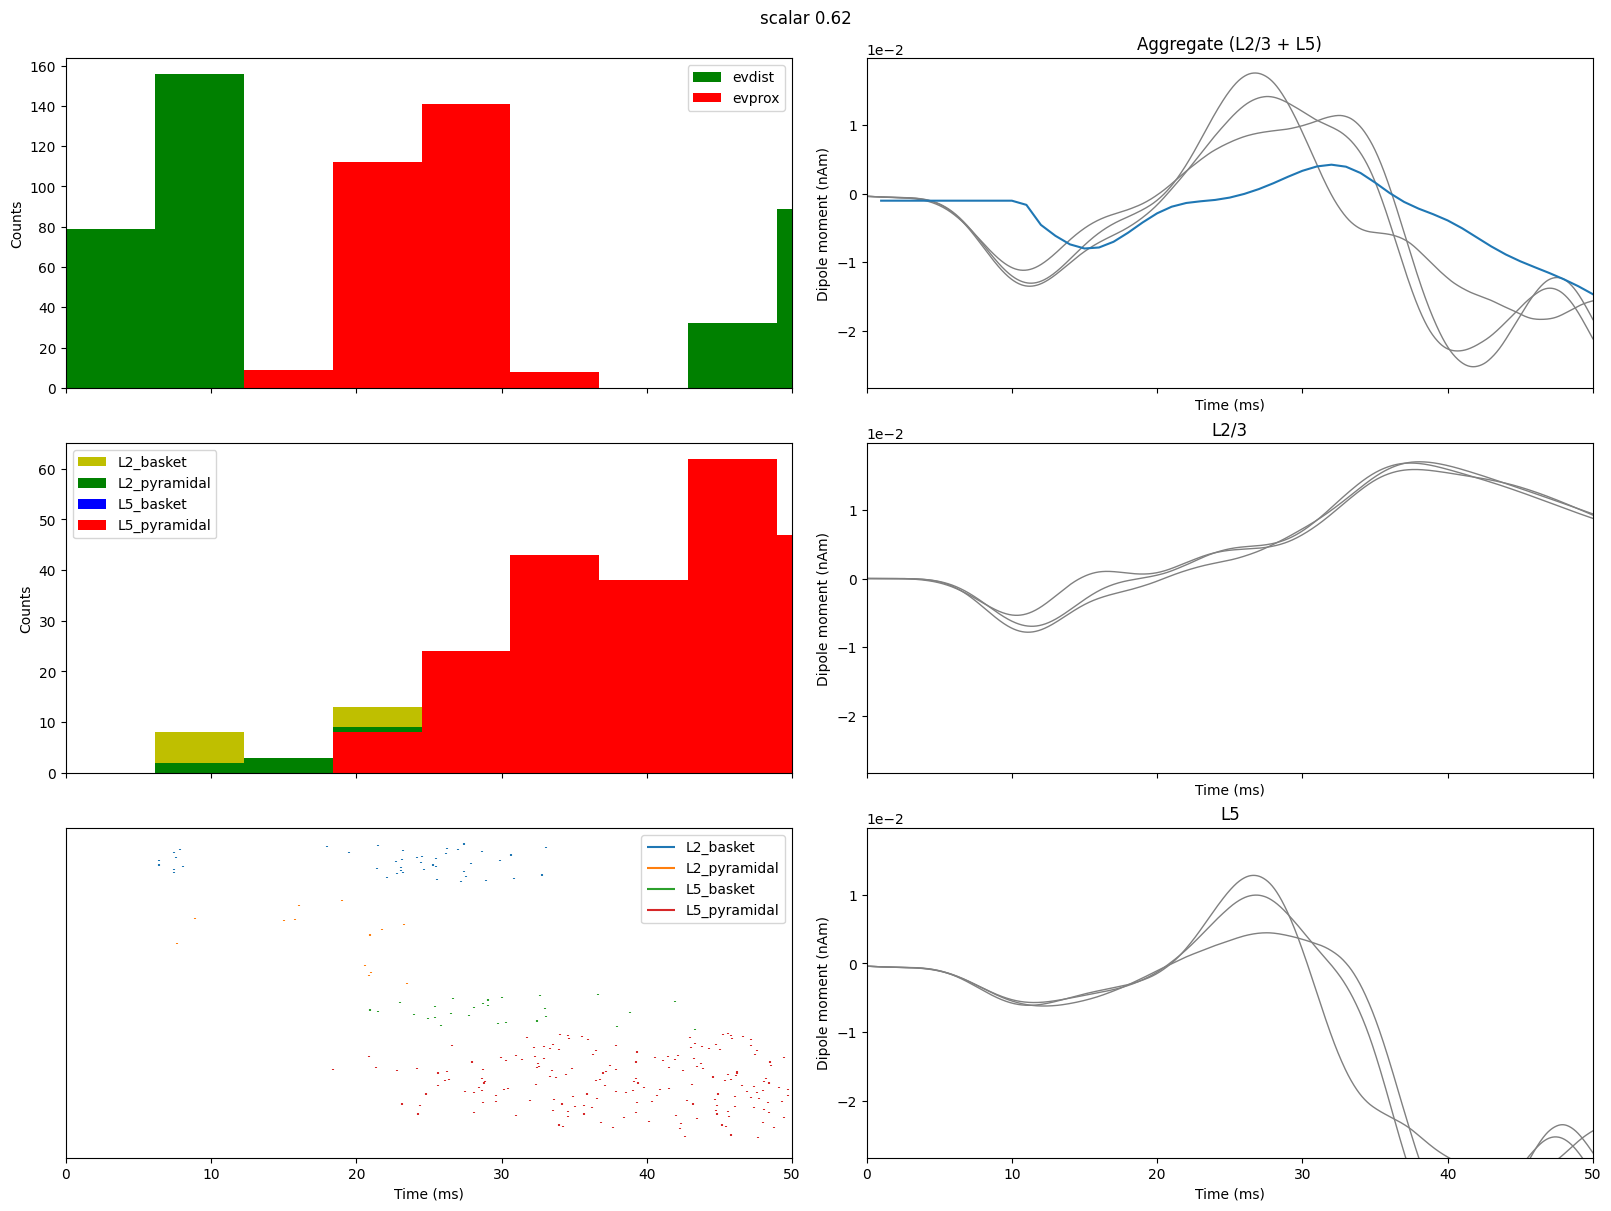

In [36]:
dist1_nets, dist1_dpls = simulate_from_params(dist1_params_list, n_trials=3)
scale_and_smooth(dist1_dpls,window_len=30)
make_plot(dist1_dpls, dist1_nets, dist_1_scalars, tstop=50)

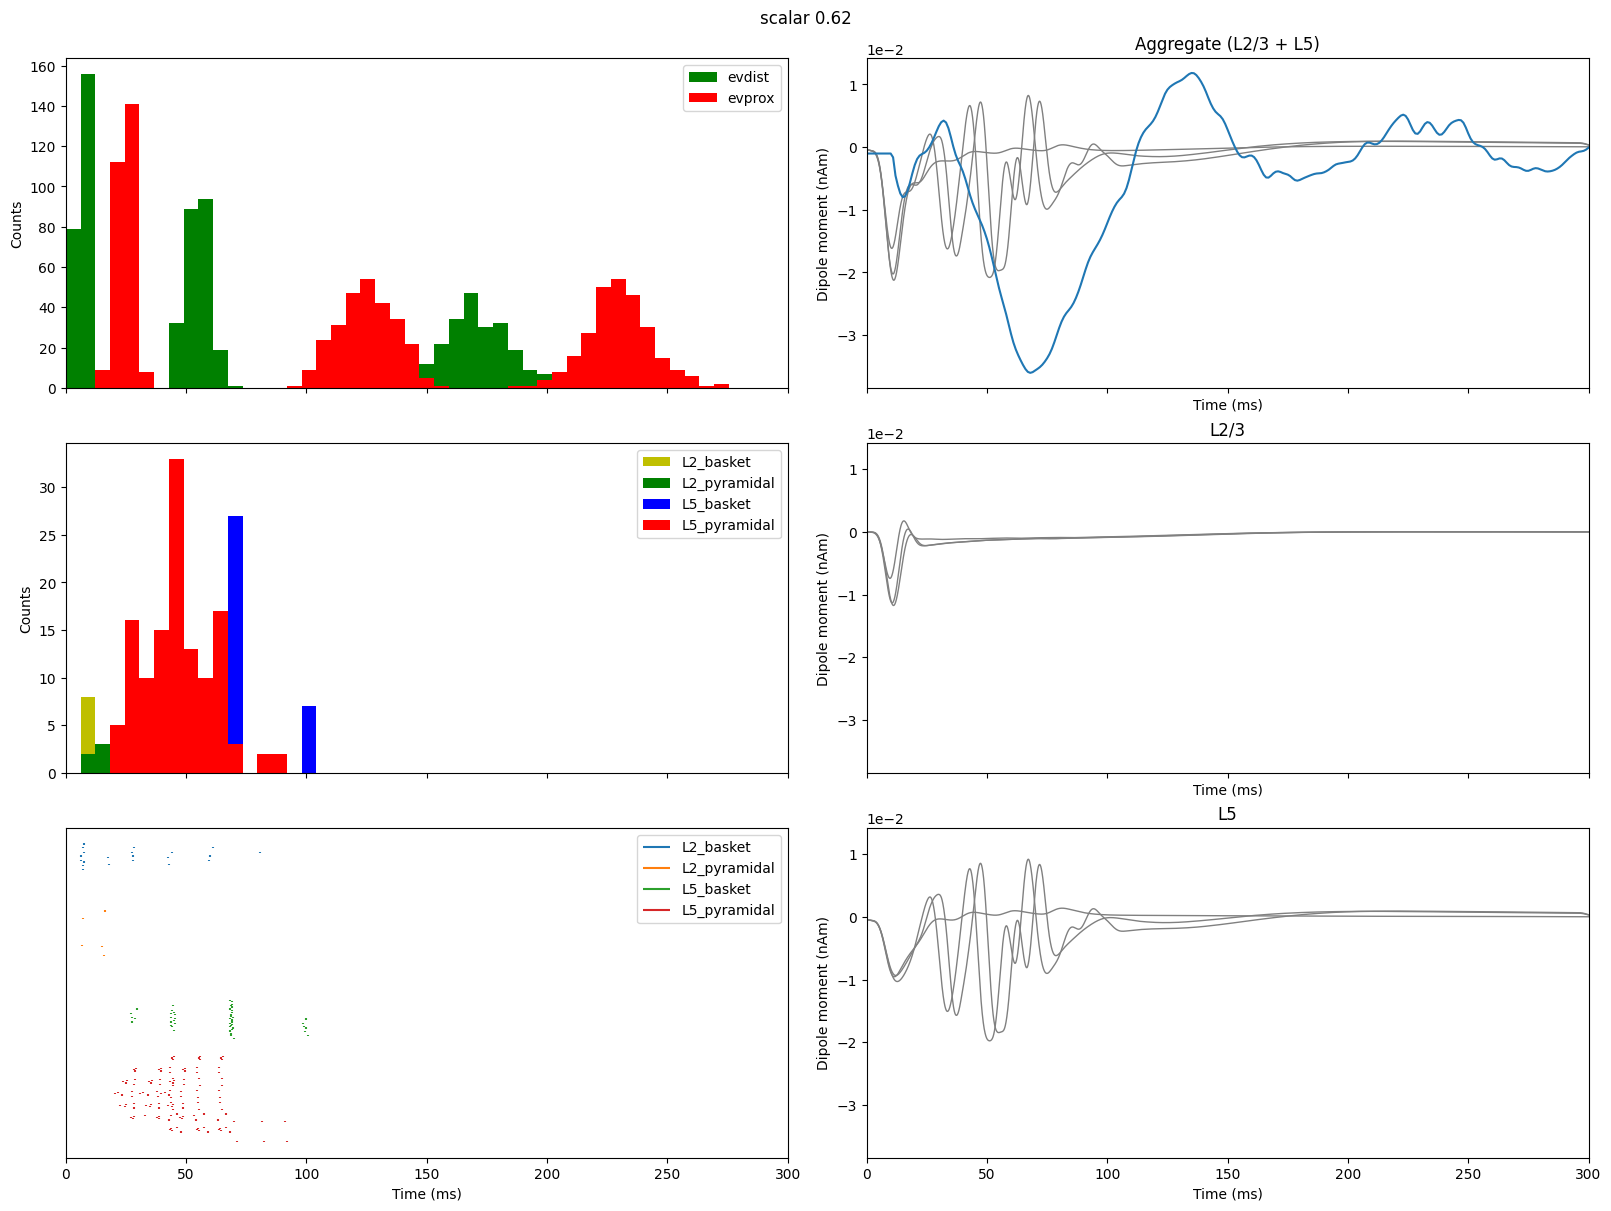

In [27]:
scale_and_smooth(dist1_dpls,window_len=10)
make_plot(dist1_dpls, dist1_nets, dist_1_scalars, tstop=300)

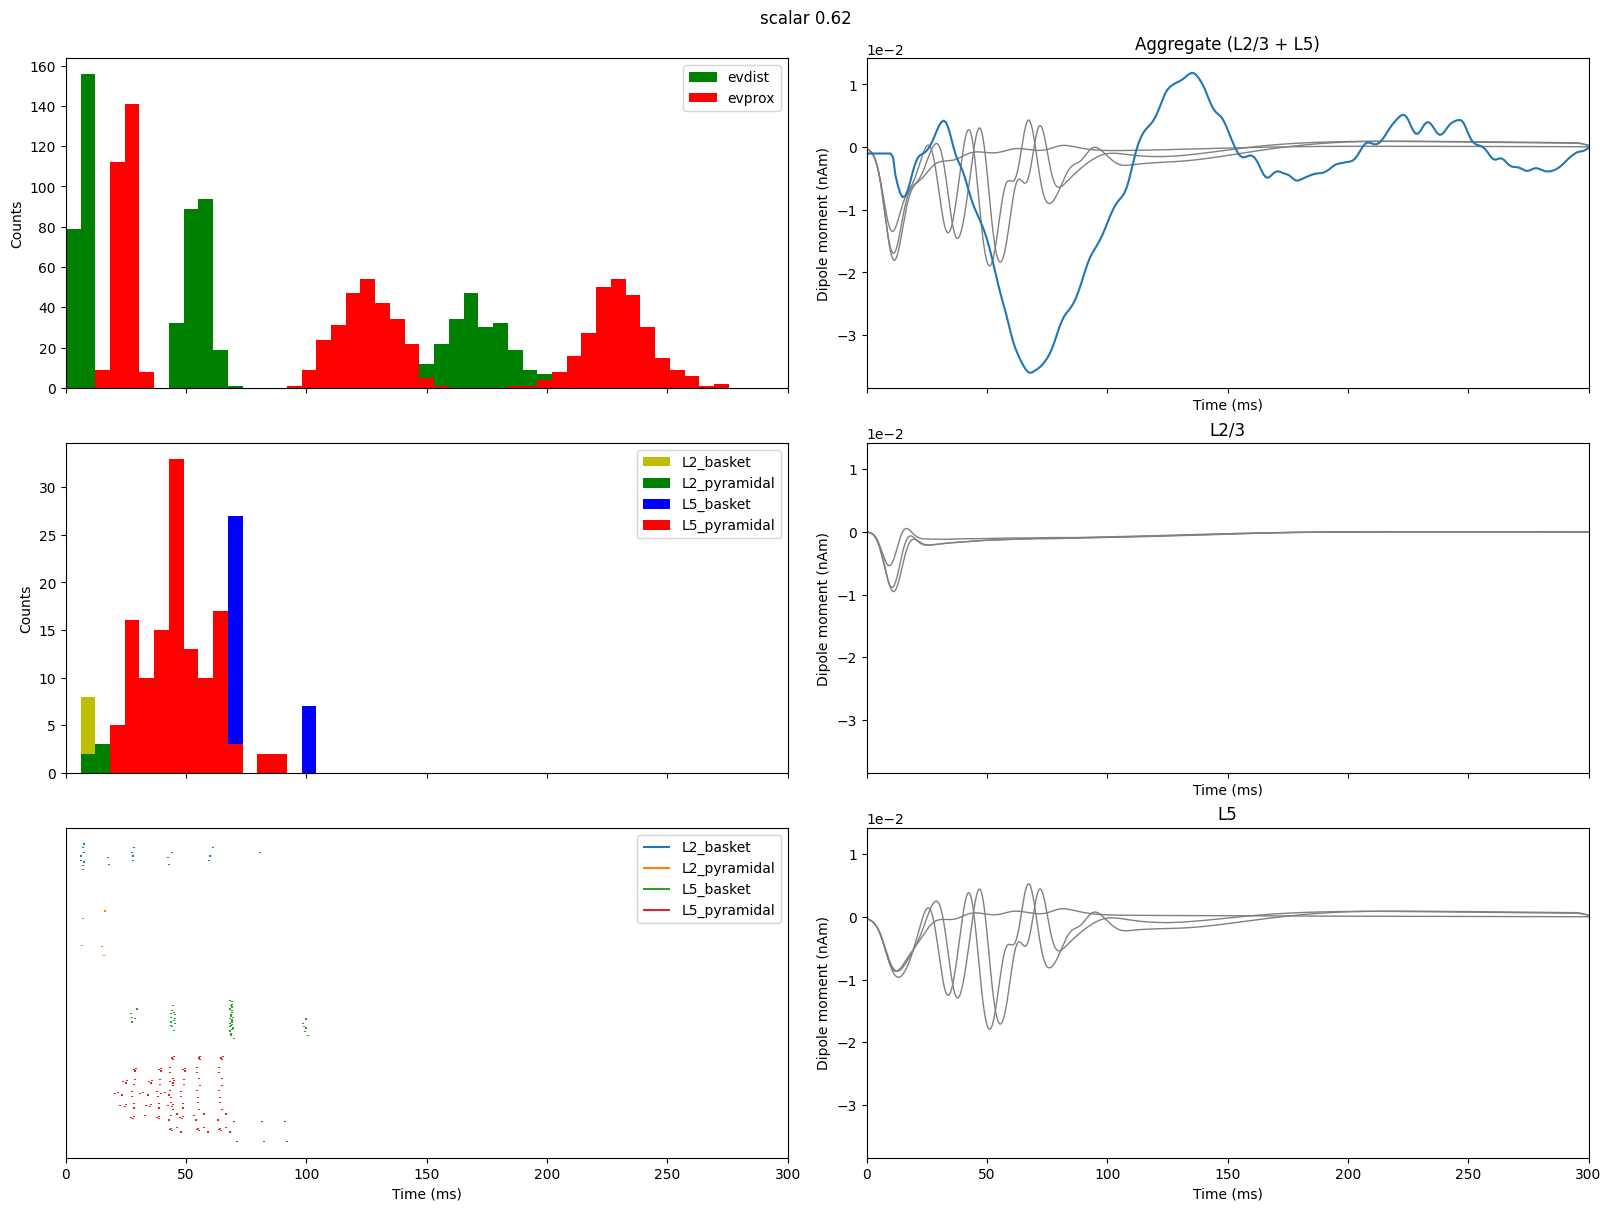

In [28]:
smoothed_dist1_dpls = scale_and_smooth(dist1_dpls)
make_plot(smoothed_dist1_dpls, dist1_nets, dist_1_scalars, tstop=300, trial_idx=0)

In [71]:
dist1_nets[0].external_drives['events']

KeyError: 'events'

In [74]:
dist1_nets[1].gid_ranges

OrderedDict([('L2_basket', range(0, 35)),
             ('L2_pyramidal', range(35, 135)),
             ('L5_basket', range(135, 170)),
             ('L5_pyramidal', range(170, 270)),
             ('evdist1', range(270, 505)),
             ('evdist2', range(505, 740)),
             ('evdist3', range(740, 975)),
             ('evprox1', range(975, 1245)),
             ('evprox2', range(1245, 1515)),
             ('evprox3', range(1515, 1785))])